In [90]:
import json
import numpy as np
import pandas as pd

import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import pyLDAvis
from gensim.corpora import Dictionary, MmCorpus
import nltk

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


import preprocessor as p # 
import string # use string.punctuation to clean out punctuation

from pprint import pprint

from datetime import datetime
import pickle



from tqdm import tqdm

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [31]:
with open("clean_tweets_sample.pkl", 'rb') as picklefile: 
    sampleDF = pickle.load(picklefile)

In [32]:
with open("clean_tweets_full.pkl", 'rb') as picklefile: 
    fullDF = pickle.load(picklefile)

In [33]:
def just_text(tweetsDF):
    cleanDF = pd.DataFrame(columns = ['id','full_text'])
    cleanDF['full_text'] = tweetsDF['full_text']
    cleanDF.drop('id',axis = 1).head()
    return cleanDF

In [34]:
sampletextDF = just_text(sampleDF)

In [50]:
sampleDF.head()

,user,created_at,full_text,truncated,contains_url,favorite_count,location,time_zone,following_count,followers_count,retweet_count,Polarity,Subjectivity
0,MartinKACrook,2018-02-28 22:32:24+00:00,population control will not reverse or mitigate climate change here is the logic and evidence populationcontrollaw,False,1,0,None,Amsterdam,94,71,0,0.00000,0.00000
1,AggieHJ,2018-02-28 22:32:06+00:00,i see climate change deniers are out in force today due to the cold weather in europe they still haven t bothered to research the issue properly and are still hung up on the global warming meaning climatechangeisreal,False,1,0,None,None,218,307,0,-0.18125,0.36875
2,MadonnaMadsen,2018-02-28 22:32:00+00:00,convenient truth al gore the father of global warming suggest that we tax ranchers cows passing gas he owns mansion flies around in his personal jet and leaves a carbon footprint like a herd of elephants now the dems switch the name climate change what a hoax,False,1,0,None,Central Time (US & Canada),10202,10713,3,0.00000,0.15000
3,hackneywick,2018-02-28 22:31:58+00:00,and yes it s consistent with climate change warming at the poles weakens the jetstream which blows warm air from the west and allows colder air in from the east,False,1,0,None,London,7031,8057,2,0.42500,0.42500
4,ONGYEWKHOON5,2018-02-28 22:31:19+00:00,can lee s l do something to safe the global warming and climate changes,False,1,0,Singapore,None,3896,806,0,0.25000,0.25000


In [35]:
fulltextDF = just_text(fullDF)

In [36]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en')

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/Users/emilygeller/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/Users/emilygeller/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/Users/emilygeller/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).res

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/Users/emilygeller/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/Users/emilygeller/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/Users/emilygeller/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]


In [37]:
def get_tokens(text):  
    """Return lemmatized tokens."""
    text = re.sub(r"http\S+", "", text) 
    text = re.sub("RT", "", text)
    text = re.sub("amp", "", text)
    letters_only = re.sub("[^a-zA-Z]", " ", text) 
    words = ' '.join(letters_only.lower().split())
    #try:
    tokens = [token.lemma_ for token in nlp(words)] 
    #except:
        #tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] 
    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n']
    return ' '.join(filtered)

In [38]:
sampletextDF['tokens'] = sampletextDF['full_text'].apply(get_tokens)

In [39]:
fulltextDF['tokens'] = fulltextDF['full_text'].apply(get_tokens)

KeyboardInterrupt: 

In [175]:
def nltk_stopwords():
    stopwords = nltk.corpus.stopwords.words('english')
    newStopWords = ['change','global', 'warming', 'climate', 'climatechange', 'globalwarming']
    stopwords.extend(newStopWords)
    
    return stopwords

def prep_corpus(docs,  no_below=5, no_above=0.5):
    print('Building dictionary...')
    docs = [doc.split() for doc in docs]
    dictionary = Dictionary(docs)
    stopwords = nltk_stopwords()
    stopword_ids = map(dictionary.token2id.get, stopwords)
    dictionary.filter_tokens(stopword_ids)
    dictionary.compactify()
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()

    print('Building corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return dictionary, corpus

# LDA on Sample

In [41]:
sampletextDF.tokens[0].split()

['population',
 'control',
 'will',
 'not',
 'reverse',
 'or',
 'mitigate',
 'climate',
 'change',
 'here',
 'be',
 'the',
 'logic',
 'and',
 'evidence',
 'populationcontrollaw']

In [42]:
sampledictionary, samplecorpus = prep_corpus(sampletextDF.tokens)

Building dictionary...


2018-03-07 14:00:11,222 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-07 14:00:11,531 : INFO : adding document #10000 to Dictionary(6191 unique tokens: ['and', 'be', 'change', 'climate', 'control']...)
2018-03-07 14:00:11,751 : INFO : built Dictionary(8388 unique tokens: ['and', 'be', 'change', 'climate', 'control']...) from 17579 documents (total 413227 corpus positions)
2018-03-07 14:00:11,775 : INFO : discarding 5331 tokens: [('climate', 9028), ('logic', 2), ('populationcontrollaw', 1), ('-PRON-', 9472), ('hang', 1), ('properly', 3), ('warming', 9211), ('herd', 4), ('mansion', 4), ('lee', 1)]...
2018-03-07 14:00:11,776 : INFO : keeping 2943 tokens which were in no less than 5 and no more than 8789 (=50.0%) documents
2018-03-07 14:00:11,781 : INFO : resulting dictionary: Dictionary(2943 unique tokens: ['control', 'evidence', 'mitigate', 'population', 'reverse']...)


Building corpus...


In [43]:
samplelda = models.ldamodel.LdaModel(corpus=samplecorpus, id2word=sampledictionary, num_topics=5, passes=10)

2018-03-07 14:00:15,906 : INFO : using symmetric alpha at 0.2
2018-03-07 14:00:15,909 : INFO : using symmetric eta at 0.2
2018-03-07 14:00:15,911 : INFO : using serial LDA version on this node
2018-03-07 14:00:16,001 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 17579 documents, updating model once every 2000 documents, evaluating perplexity every 17579 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-07 14:00:16,003 : INFO : PROGRESS: pass 0, at document #2000/17579
2018-03-07 14:00:18,650 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:00:18,658 : INFO : topic #0 (0.200): 0.020*"cause" + 0.019*"arctic" + 0.018*"million" + 0.016*"plant" + 0.015*"snow" + 0.015*"know" + 0.014*"tree" + 0.013*"weather" + 0.013*"hour" + 0.012*"india"
2018-03-07 14:00:18,661 : INFO : topic #1 (0.200): 0.045*"think" + 0.042*"world" + 0.042*"around" + 0.041*"start" + 0.041*"may" + 0.040*"op

2018-03-07 14:00:24,504 : INFO : topic diff=0.562166, rho=0.408248
2018-03-07 14:00:24,506 : INFO : PROGRESS: pass 0, at document #14000/17579
2018-03-07 14:00:25,481 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:00:25,501 : INFO : topic #0 (0.200): 0.024*"extreme" + 0.024*"normal" + 0.023*"degree" + 0.021*"effect" + 0.020*"weather" + 0.019*"science" + 0.018*"high" + 0.017*"pollution" + 0.014*"ice" + 0.014*"artic"
2018-03-07 14:00:25,502 : INFO : topic #1 (0.200): 0.087*"mind" + 0.085*"six" + 0.085*"american" + 0.053*"world" + 0.032*"around" + 0.030*"lake" + 0.025*"via" + 0.020*"big" + 0.017*"dry" + 0.014*"century"
2018-03-07 14:00:25,504 : INFO : topic #2 (0.200): 0.028*"climatechange" + 0.019*"scientist" + 0.014*"due" + 0.012*"one" + 0.012*"year" + 0.011*"say" + 0.010*"make" + 0.008*"may" + 0.008*"daily" + 0.008*"depend"
2018-03-07 14:00:25,506 : INFO : topic #3 (0.200): 0.041*"climatechange" + 0.033*"record" + 0.030*"want" + 0.029*"mean" 

2018-03-07 14:00:33,025 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:00:33,036 : INFO : topic #0 (0.200): 0.044*"extreme" + 0.030*"ice" + 0.030*"science" + 0.030*"degree" + 0.028*"nothing" + 0.027*"denial" + 0.027*"artic" + 0.026*"eerienc" + 0.026*"economic" + 0.026*"profit"
2018-03-07 14:00:33,038 : INFO : topic #1 (0.200): 0.059*"world" + 0.042*"lake" + 0.027*"big" + 0.027*"penguin" + 0.026*"king" + 0.022*"dry" + 0.022*"mind" + 0.022*"around" + 0.021*"century" + 0.021*"american"
2018-03-07 14:00:33,040 : INFO : topic #2 (0.200): 0.025*"climatechange" + 0.023*"scientist" + 0.013*"say" + 0.011*"cause" + 0.011*"one" + 0.009*"winter" + 0.009*"arctic" + 0.009*"many" + 0.009*"warm" + 0.008*"ocean"
2018-03-07 14:00:33,042 : INFO : topic #3 (0.200): 0.045*"plant" + 0.043*"tree" + 0.040*"million" + 0.034*"climatechange" + 0.027*"mean" + 0.027*"want" + 0.025*"average" + 0.024*"hour" + 0.024*"give" + 0.024*"property"
2018-03-07 14:00:33,044 : INFO :

2018-03-07 14:00:40,052 : INFO : topic #1 (0.200): 0.048*"world" + 0.042*"lake" + 0.036*"mind" + 0.035*"around" + 0.034*"six" + 0.034*"american" + 0.024*"century" + 0.022*"via" + 0.021*"end" + 0.021*"big"
2018-03-07 14:00:40,054 : INFO : topic #2 (0.200): 0.018*"climatechange" + 0.018*"warm" + 0.015*"say" + 0.015*"many" + 0.014*"science" + 0.013*"would" + 0.012*"ocean" + 0.012*"scientist" + 0.010*"faster" + 0.010*"like"
2018-03-07 14:00:40,055 : INFO : topic #3 (0.200): 0.056*"tree" + 0.055*"plant" + 0.049*"million" + 0.043*"india" + 0.043*"record" + 0.041*"hour" + 0.039*"part" + 0.036*"environmental" + 0.036*"break" + 0.035*"caign"
2018-03-07 14:00:40,057 : INFO : topic #4 (0.200): 0.035*"warm" + 0.017*"rise" + 0.017*"sea" + 0.014*"weather" + 0.014*"climatechange" + 0.013*"level" + 0.012*"need" + 0.011*"cold" + 0.011*"emission" + 0.011*"arctic"
2018-03-07 14:00:40,059 : INFO : topic diff=0.247373, rho=0.291241
2018-03-07 14:00:40,060 : INFO : PROGRESS: pass 2, at document #4000/17579


2018-03-07 14:00:44,724 : INFO : topic #3 (0.200): 0.042*"climatechange" + 0.032*"record" + 0.031*"want" + 0.031*"mean" + 0.028*"tree" + 0.026*"million" + 0.026*"give" + 0.024*"plant" + 0.023*"address" + 0.023*"ride"
2018-03-07 14:00:44,726 : INFO : topic #4 (0.200): 0.026*"warm" + 0.021*"sea" + 0.019*"rise" + 0.016*"climatechange" + 0.015*"arctic" + 0.013*"level" + 0.012*"weather" + 0.012*"c" + 0.010*"planet" + 0.010*"know"
2018-03-07 14:00:44,728 : INFO : topic diff=0.208465, rho=0.291241
2018-03-07 14:00:44,730 : INFO : PROGRESS: pass 2, at document #16000/17579
2018-03-07 14:00:45,633 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:00:45,640 : INFO : topic #0 (0.200): 0.032*"plant" + 0.028*"pollution" + 0.027*"year" + 0.025*"china" + 0.023*"soldier" + 0.021*"ireland" + 0.021*"degree" + 0.020*"size" + 0.020*"extreme" + 0.018*"normal"
2018-03-07 14:00:45,642 : INFO : topic #1 (0.200): 0.069*"lake" + 0.058*"mind" + 0.055*"six" + 0.055*"americ

2018-03-07 14:00:50,669 : INFO : topic #4 (0.200): 0.023*"warm" + 0.022*"arctic" + 0.018*"know" + 0.016*"c" + 0.015*"planet" + 0.015*"sea" + 0.014*"climatechange" + 0.013*"think" + 0.012*"good" + 0.012*"let"
2018-03-07 14:00:50,672 : INFO : topic diff=0.180532, rho=0.279623
2018-03-07 14:00:50,674 : INFO : PROGRESS: pass 3, at document #10000/17579
2018-03-07 14:00:51,395 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:00:51,400 : INFO : topic #0 (0.200): 0.034*"extreme" + 0.030*"normal" + 0.025*"ice" + 0.023*"degree" + 0.023*"science" + 0.022*"nothing" + 0.022*"year" + 0.021*"economic" + 0.021*"denial" + 0.020*"artic"
2018-03-07 14:00:51,401 : INFO : topic #1 (0.200): 0.054*"world" + 0.040*"lake" + 0.030*"big" + 0.026*"mind" + 0.025*"american" + 0.024*"six" + 0.022*"dry" + 0.021*"penguin" + 0.021*"via" + 0.020*"king"
2018-03-07 14:00:51,403 : INFO : topic #2 (0.200): 0.022*"climatechange" + 0.020*"warm" + 0.017*"scientist" + 0.012*"one" + 0.0

2018-03-07 14:00:56,421 : INFO : topic diff=0.202413, rho=0.269293
2018-03-07 14:00:56,423 : INFO : PROGRESS: pass 4, at document #4000/17579
2018-03-07 14:00:57,195 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:00:57,200 : INFO : topic #0 (0.200): 0.025*"plant" + 0.024*"year" + 0.022*"extreme" + 0.020*"ice" + 0.019*"degree" + 0.018*"china" + 0.018*"pollution" + 0.017*"effect" + 0.016*"soldier" + 0.015*"fight"
2018-03-07 14:00:57,202 : INFO : topic #1 (0.200): 0.042*"world" + 0.032*"around" + 0.029*"mind" + 0.029*"lake" + 0.026*"american" + 0.025*"six" + 0.022*"future" + 0.021*"end" + 0.021*"may" + 0.020*"start"
2018-03-07 14:00:57,204 : INFO : topic #2 (0.200): 0.030*"warm" + 0.016*"scientist" + 0.015*"climatechange" + 0.014*"say" + 0.012*"science" + 0.011*"cause" + 0.010*"many" + 0.010*"even" + 0.009*"winter" + 0.009*"human"
2018-03-07 14:00:57,206 : INFO : topic #3 (0.200): 0.051*"million" + 0.046*"hour" + 0.046*"tree" + 0.044*"plant" + 0

2018-03-07 14:01:01,382 : INFO : topic #1 (0.200): 0.066*"lake" + 0.056*"mind" + 0.054*"six" + 0.054*"american" + 0.043*"world" + 0.035*"air" + 0.027*"around" + 0.025*"via" + 0.024*"big" + 0.019*"despite"
2018-03-07 14:01:01,383 : INFO : topic #2 (0.200): 0.054*"warm" + 0.025*"many" + 0.023*"faster" + 0.019*"ocean" + 0.016*"climatechange" + 0.015*"say" + 0.014*"california" + 0.010*"scientist" + 0.010*"way" + 0.010*"city"
2018-03-07 14:01:01,385 : INFO : topic #3 (0.200): 0.048*"climatechange" + 0.033*"mean" + 0.032*"want" + 0.030*"record" + 0.029*"paris" + 0.028*"agreement" + 0.027*"give" + 0.026*"million" + 0.025*"address" + 0.024*"ride"
2018-03-07 14:01:01,387 : INFO : topic #4 (0.200): 0.027*"sea" + 0.026*"rise" + 0.022*"warm" + 0.020*"level" + 0.016*"climatechange" + 0.013*"arctic" + 0.012*"weather" + 0.011*"c" + 0.010*"planet" + 0.009*"know"
2018-03-07 14:01:01,388 : INFO : topic diff=0.130219, rho=0.269293
2018-03-07 14:01:02,371 : INFO : -7.122 per-word bound, 139.3 perplexity e

2018-03-07 14:01:06,438 : INFO : topic #2 (0.200): 0.022*"warm" + 0.020*"climatechange" + 0.016*"scientist" + 0.011*"science" + 0.011*"one" + 0.011*"say" + 0.009*"cause" + 0.009*"year" + 0.008*"many" + 0.008*"due"
2018-03-07 14:01:06,439 : INFO : topic #3 (0.200): 0.047*"million" + 0.045*"climatechange" + 0.034*"mean" + 0.034*"want" + 0.033*"tree" + 0.032*"plant" + 0.029*"give" + 0.028*"part" + 0.027*"address" + 0.026*"record"
2018-03-07 14:01:06,441 : INFO : topic #4 (0.200): 0.028*"arctic" + 0.024*"c" + 0.022*"warm" + 0.018*"know" + 0.016*"hot" + 0.016*"planet" + 0.014*"good" + 0.014*"think" + 0.013*"climatechange" + 0.013*"let"
2018-03-07 14:01:06,443 : INFO : topic diff=0.143298, rho=0.260030
2018-03-07 14:01:06,444 : INFO : PROGRESS: pass 5, at document #12000/17579
2018-03-07 14:01:07,266 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:01:07,270 : INFO : topic #0 (0.200): 0.032*"extreme" + 0.026*"normal" + 0.022*"degree" + 0.022*"effect"

2018-03-07 14:01:11,835 : INFO : topic #3 (0.200): 0.050*"million" + 0.045*"hour" + 0.044*"tree" + 0.044*"record" + 0.043*"plant" + 0.043*"india" + 0.038*"part" + 0.038*"climatechange" + 0.032*"environmental" + 0.031*"break"
2018-03-07 14:01:11,837 : INFO : topic #4 (0.200): 0.018*"warm" + 0.018*"arctic" + 0.017*"sea" + 0.016*"rise" + 0.016*"weather" + 0.015*"climatechange" + 0.012*"cold" + 0.011*"temperature" + 0.011*"level" + 0.009*"planet"
2018-03-07 14:01:11,838 : INFO : topic diff=0.147685, rho=0.251661
2018-03-07 14:01:11,840 : INFO : PROGRESS: pass 6, at document #6000/17579
2018-03-07 14:01:12,657 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:01:12,663 : INFO : topic #0 (0.200): 0.036*"extreme" + 0.026*"ice" + 0.023*"degree" + 0.021*"year" + 0.021*"science" + 0.020*"nothing" + 0.020*"effect" + 0.019*"artic" + 0.019*"economic" + 0.019*"eerienc"
2018-03-07 14:01:12,664 : INFO : topic #1 (0.200): 0.038*"world" + 0.028*"penguin" + 0.027*

2018-03-07 14:01:16,130 : INFO : topic diff=0.115838, rho=0.251661
2018-03-07 14:01:17,417 : INFO : -7.101 per-word bound, 137.3 perplexity estimate based on a held-out corpus of 1579 documents with 19769 words
2018-03-07 14:01:17,419 : INFO : PROGRESS: pass 6, at document #17579/17579
2018-03-07 14:01:18,017 : INFO : merging changes from 1579 documents into a model of 17579 documents
2018-03-07 14:01:18,021 : INFO : topic #0 (0.200): 0.033*"plant" + 0.026*"year" + 0.025*"pollution" + 0.024*"china" + 0.021*"degree" + 0.021*"soldier" + 0.021*"fight" + 0.020*"tree" + 0.018*"extreme" + 0.016*"forest"
2018-03-07 14:01:18,023 : INFO : topic #1 (0.200): 0.052*"lake" + 0.045*"mind" + 0.044*"six" + 0.044*"american" + 0.038*"world" + 0.029*"century" + 0.028*"end" + 0.026*"via" + 0.026*"around" + 0.025*"air"
2018-03-07 14:01:18,024 : INFO : topic #2 (0.200): 0.042*"warm" + 0.018*"climatechange" + 0.016*"many" + 0.014*"science" + 0.013*"faster" + 0.012*"say" + 0.012*"would" + 0.011*"co" + 0.011*"

2018-03-07 14:01:22,180 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:01:22,183 : INFO : topic #0 (0.200): 0.032*"extreme" + 0.026*"normal" + 0.023*"degree" + 0.022*"effect" + 0.022*"ice" + 0.020*"year" + 0.019*"science" + 0.018*"nothing" + 0.018*"artic" + 0.018*"pollution"
2018-03-07 14:01:22,185 : INFO : topic #1 (0.200): 0.047*"world" + 0.042*"six" + 0.042*"mind" + 0.040*"american" + 0.036*"lake" + 0.028*"big" + 0.021*"century" + 0.021*"dry" + 0.020*"via" + 0.020*"around"
2018-03-07 14:01:22,187 : INFO : topic #2 (0.200): 0.020*"warm" + 0.018*"climatechange" + 0.014*"scientist" + 0.010*"one" + 0.010*"science" + 0.010*"say" + 0.009*"cause" + 0.008*"year" + 0.008*"like" + 0.008*"due"
2018-03-07 14:01:22,189 : INFO : topic #3 (0.200): 0.045*"climatechange" + 0.034*"million" + 0.033*"want" + 0.033*"mean" + 0.031*"record" + 0.028*"give" + 0.026*"address" + 0.025*"ride" + 0.025*"suvs" + 0.025*"helicopter"
2018-03-07 14:01:22,190 : INFO : topic 

2018-03-07 14:01:27,125 : INFO : topic #1 (0.200): 0.038*"world" + 0.028*"penguin" + 0.027*"king" + 0.025*"century" + 0.025*"lake" + 0.024*"mind" + 0.024*"end" + 0.022*"around" + 0.022*"american" + 0.022*"six"
2018-03-07 14:01:27,126 : INFO : topic #2 (0.200): 0.027*"warm" + 0.018*"climatechange" + 0.016*"scientist" + 0.013*"say" + 0.011*"science" + 0.010*"cause" + 0.010*"many" + 0.008*"winter" + 0.008*"human" + 0.008*"one"
2018-03-07 14:01:27,128 : INFO : topic #3 (0.200): 0.048*"million" + 0.042*"climatechange" + 0.039*"tree" + 0.038*"plant" + 0.038*"record" + 0.036*"hour" + 0.035*"india" + 0.033*"part" + 0.031*"mean" + 0.030*"want"
2018-03-07 14:01:27,130 : INFO : topic #4 (0.200): 0.021*"warm" + 0.020*"arctic" + 0.019*"sea" + 0.015*"weather" + 0.014*"climatechange" + 0.013*"rise" + 0.012*"know" + 0.011*"temperature" + 0.010*"time" + 0.010*"study"
2018-03-07 14:01:27,132 : INFO : topic diff=0.170078, rho=0.237093
2018-03-07 14:01:27,134 : INFO : PROGRESS: pass 8, at document #8000/1

2018-03-07 14:01:32,044 : INFO : topic #2 (0.200): 0.041*"warm" + 0.018*"climatechange" + 0.015*"many" + 0.014*"science" + 0.013*"faster" + 0.012*"say" + 0.012*"human" + 0.012*"need" + 0.011*"ocean" + 0.011*"would"
2018-03-07 14:01:32,046 : INFO : topic #3 (0.200): 0.055*"climatechange" + 0.034*"mean" + 0.033*"want" + 0.028*"give" + 0.027*"address" + 0.026*"ride" + 0.026*"suvs" + 0.026*"exnknew" + 0.026*"helicopter" + 0.026*"actonclimate"
2018-03-07 14:01:32,048 : INFO : topic #4 (0.200): 0.023*"sea" + 0.022*"rise" + 0.020*"warm" + 0.017*"level" + 0.016*"climatechange" + 0.012*"arctic" + 0.012*"weather" + 0.011*"planet" + 0.010*"c" + 0.009*"good"
2018-03-07 14:01:32,049 : INFO : topic diff=0.147566, rho=0.237093
2018-03-07 14:01:32,051 : INFO : PROGRESS: pass 9, at document #2000/17579
2018-03-07 14:01:32,752 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:01:32,756 : INFO : topic #0 (0.200): 0.031*"plant" + 0.025*"year" + 0.023*"pollution" + 

2018-03-07 14:01:36,059 : INFO : topic #4 (0.200): 0.021*"arctic" + 0.020*"warm" + 0.017*"sea" + 0.017*"c" + 0.015*"weather" + 0.014*"planet" + 0.014*"rise" + 0.013*"know" + 0.012*"climatechange" + 0.012*"good"
2018-03-07 14:01:36,061 : INFO : topic diff=0.134804, rho=0.230697
2018-03-07 14:01:36,062 : INFO : PROGRESS: pass 9, at document #14000/17579
2018-03-07 14:01:36,659 : INFO : merging changes from 2000 documents into a model of 17579 documents
2018-03-07 14:01:36,662 : INFO : topic #0 (0.200): 0.030*"extreme" + 0.025*"normal" + 0.025*"degree" + 0.021*"year" + 0.021*"effect" + 0.020*"ice" + 0.019*"science" + 0.018*"pollution" + 0.017*"plant" + 0.017*"china"
2018-03-07 14:01:36,664 : INFO : topic #1 (0.200): 0.065*"mind" + 0.063*"six" + 0.062*"american" + 0.038*"world" + 0.031*"lake" + 0.028*"around" + 0.024*"via" + 0.022*"big" + 0.017*"century" + 0.016*"dry"
2018-03-07 14:01:36,665 : INFO : topic #2 (0.200): 0.022*"warm" + 0.018*"climatechange" + 0.013*"scientist" + 0.011*"say" +

In [44]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [45]:
sample_vis_data = gensimvis.prepare(samplelda, samplecorpus, sampledictionary)
pyLDAvis.display(sample_vis_data)

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


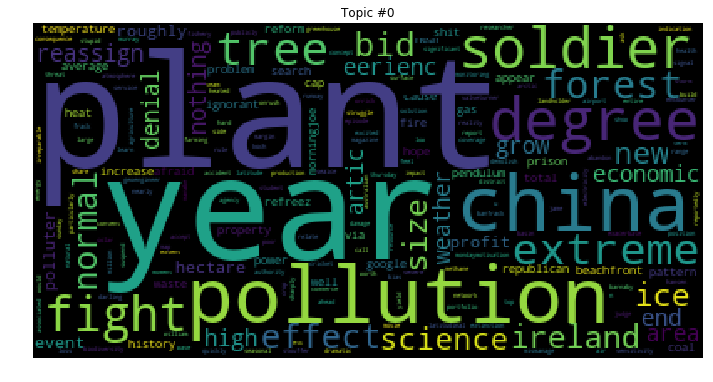

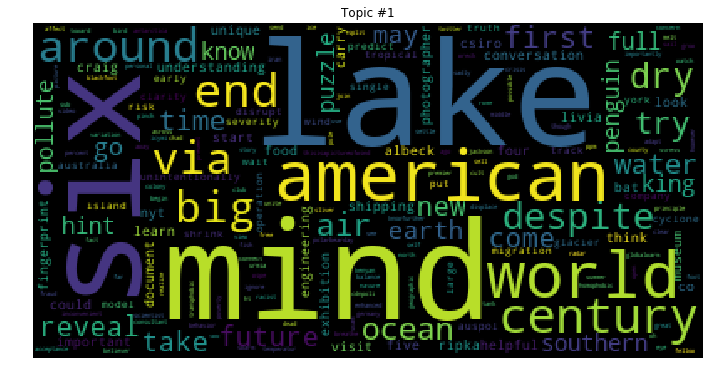

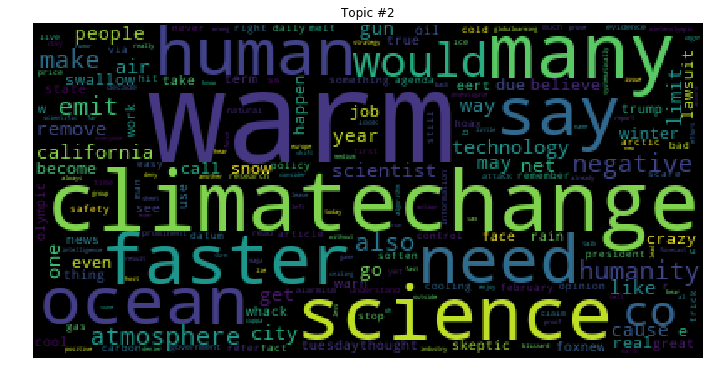

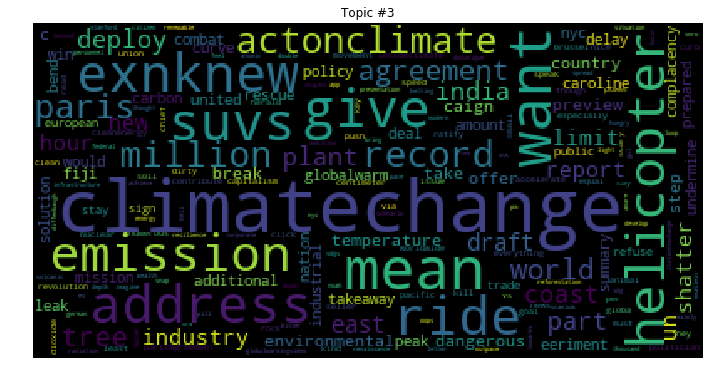

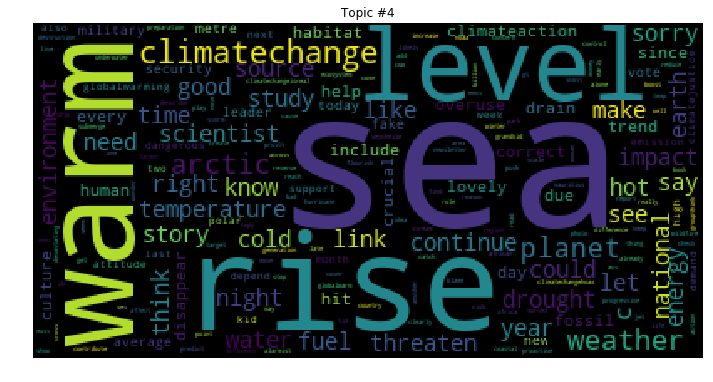

In [46]:
for t in range(samplelda.num_topics):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud().fit_words(dict(samplelda.show_topic(t,200))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

# LDA on Full Set

In [ ]:
fulltextDF.tokens[0].split()

In [ ]:
full_dictionary, full_corpus = prep_corpus(fulltextDF.tokens)

In [ ]:
full_lda = models.ldamodel.LdaModel(corpus=full_corpus, id2word=full_dictionary, num_topics=5, passes=10)

In [ ]:
full_vis_data = gensimvis.prepare(full_lda, full_corpus, full_dictionary)
pyLDAvis.display(full_vis_data)

In [ ]:
for t in range(full_lda.num_topics):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud().fit_words(dict(full_lda.show_topic(t,200))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

# PyLDAVis

Add column with topic for document

In [53]:
def print_top_words(model, feature_names, n_top_words = 20):
   #"""Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print ("\nTopic #%d:" % topic_idx)
        print (", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [164]:
def get_topics_lda(df, n_topics):  
    count_vect = CountVectorizer(analyzer = "word",
                                      stop_words = nltk_stopwords(),
                                      #max_features = 1000,
                                      max_df = 0.7,
                                      min_df = 2)
    matrix = count_vect.fit_transform(df)
    vocab = count_vect.get_feature_names()


   # fit transform lda
    lda = LatentDirichletAllocation(n_components=n_topics,
               learning_method='online', learning_offset=50., max_iter=10,
               random_state=0)
   
    doc_topic_dists = lda.fit_transform(matrix)
   
   # print topic words
   #print "\nTopics in LDA model:", cand
    print_top_words(lda, vocab)
   
   # prepare pyLDAvis
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0)
    prepared = pyLDAvis.prepare(
           doc_lengths = df.str.len(),
           vocab = vocab,
           term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
           topic_term_dists = get_normed(lda.components_), # topics x terms
           doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics
   
    return lda, doc_topic_dists, prepared, vocab

In [165]:
def get_word_freq(topic, model, n_top_words, vocab):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    
    word_dict = {};
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
    freq = sorted(model.components_[topic])[:-n_top_words - 1: -1]
    
    words_ids = model.components_[topic].argsort()[:-n_top_words - 1:-1]
    words = [vocab[key] for key in words_ids]
    
    for i in range(n_top_words):
        word_dict[words[i]] = freq[i]

    
    return word_dict

## Sample

In [75]:
sampleDF.full_text

0        population control will not reverse or mitigate climate change here is the logic and evidence populationcontrollaw                                                                                                                                                                     
1        i see climate change deniers are out in force today due to the cold weather in europe they still haven t bothered to research the issue properly and are still hung up on the global warming meaning climatechangeisreal                                                               
2        convenient truth al gore the father of global warming suggest that we tax ranchers cows passing gas he owns mansion flies around in his personal jet and leaves a carbon footprint like a herd of elephants now the dems switch the name climate change what a hoax                    
3        and yes it s consistent with climate change warming at the poles weakens the jetstream which blows warm air from the west an

In [138]:
all_lda, all_doc_topics, all_prepared,vocab = get_topics_lda(sampleDF['full_text'], 4)


Topic #0:
trees, million, record, india, hours, plants, part, environmental, campaign, breaking, planted, pollution, forest, like, weather, gun, near, rain, increasing, make

Topic #1:
changed, americans, six, minds, arctic, year, extreme, ice, science, china, degrees, plant, normal, weather, soldiers, fight, new, planet, think, know

Topic #2:
climatechange, means, wants, address, giving, helicopter, rides, suvs, exnknew, century, could, end, globalwarming, seas, actonclimate, needs, limit, would, study, science

Topic #3:
world, lakes, rise, many, air, around, via, oceans, faster, levels, say, biggest, water, sea, paris, drying, agreement, temperature, like, earth


/Users/emilygeller/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [139]:
pyLDAvis.display(all_prepared)

In [140]:
#distribution of topics over the documents
all_doc_topics

array([[0.24948726, 0.29772321, 0.40212069, 0.05066884],
       [0.02070216, 0.30333407, 0.2713759 , 0.40458787],
       [0.01942834, 0.01977648, 0.0961338 , 0.86466138],
       ...,
       [0.04166907, 0.20948321, 0.04441205, 0.70443567],
       [0.01793417, 0.36420779, 0.4123484 , 0.20550964],
       [0.45510752, 0.02093548, 0.02093364, 0.50302335]])

In [141]:
def get_doc_topics(doc_topic_dist):
   """Return list of topics for documents, given doc topic distribution"""
   return [np.argmax(topic) for doc, topic in enumerate(doc_topic_dist)]

In [142]:
# categorize reviews by most probable topic
sampleDF['topic_LDA'] = get_doc_topics(all_doc_topics)

In [99]:
sampleDF

,user,created_at,full_text,truncated,contains_url,favorite_count,location,time_zone,following_count,followers_count,retweet_count,Polarity,Subjectivity,topic_LDA
0,MartinKACrook,2018-02-28 22:32:24+00:00,population control will not reverse or mitigate climate change here is the logic and evidence populationcontrollaw,False,1,0,None,Amsterdam,94,71,0,0.000000,0.000000,2
1,AggieHJ,2018-02-28 22:32:06+00:00,i see climate change deniers are out in force today due to the cold weather in europe they still haven t bothered to research the issue properly and are still hung up on the global warming meaning climatechangeisreal,False,1,0,None,None,218,307,0,-0.181250,0.368750,3
2,MadonnaMadsen,2018-02-28 22:32:00+00:00,convenient truth al gore the father of global warming suggest that we tax ranchers cows passing gas he owns mansion flies around in his personal jet and leaves a carbon footprint like a herd of elephants now the dems switch the name climate change what a hoax,False,1,0,None,Central Time (US & Canada),10202,10713,3,0.000000,0.150000,3
3,hackneywick,2018-02-28 22:31:58+00:00,and yes it s consistent with climate change warming at the poles weakens the jetstream which blows warm air from the west and allows colder air in from the east,False,1,0,None,London,7031,8057,2,0.425000,0.425000,3
4,ONGYEWKHOON5,2018-02-28 22:31:19+00:00,can lee s l do something to safe the global warming and climate changes,False,1,0,Singapore,None,3896,806,0,0.250000,0.250000,3
5,munkihanger,2018-02-28 22:31:16+00:00,john ashton trying to elain to mayhem and co in necessarily very simple terms that allowing fracking won t help reduce global warming and catastrophic climate breakdown wonder if they ll get the message best keep on with nvda until they do roll on the united resistance,False,1,0,None,None,222,346,4,0.333333,0.254762,3
6,tlane04,2018-02-28 22:30:31+00:00,it might seem counterintuitive but global warming plays a role in blasts of bitter cold weather the reason it influences the jet stream here s how,False,1,0,None,None,474,56,153,-0.233333,0.500000,2
7,rcjhawk86,2018-02-28 22:29:50+00:00,convenient truth al gore the father of global warming suggest that we tax ranchers cows passing gas he owns mansion flies around in his personal jet and leaves a carbon footprint like a herd of elephants now the dems switch the name climate change what a hoax,False,1,0,None,None,6380,6295,3,0.000000,0.150000,3
8,bestdoxiemom,2018-02-28 22:29:47+00:00,convenient truth al gore the father of global warming suggest that we tax ranchers cows passing gas he owns mansion flies around in his personal jet and leaves a carbon footprint like a herd of elephants now the dems switch the name climate change what a hoax,False,1,0,None,None,4991,4951,3,0.000000,0.150000,3
9,yergnflergn,2018-02-28 22:29:34+00:00,if you want to research the soyboy epidemic causes just allege a link and possible solution to global warming sorry climate change in the research grant application maybe study the combined potential of estrogen and soy flatulence to absorb co and bam the money s in the bank,False,0,0,None,None,313,197,0,-0.125000,0.750000,3


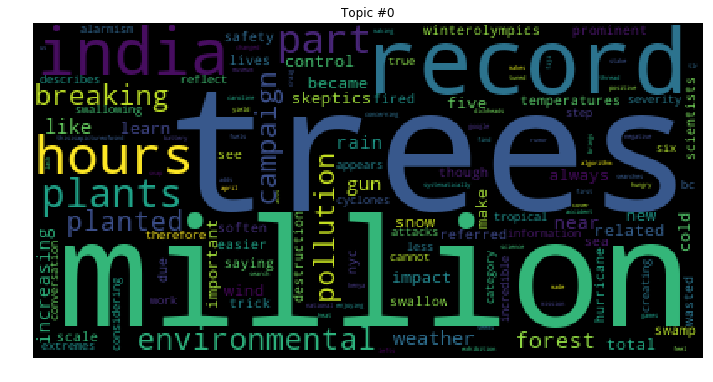

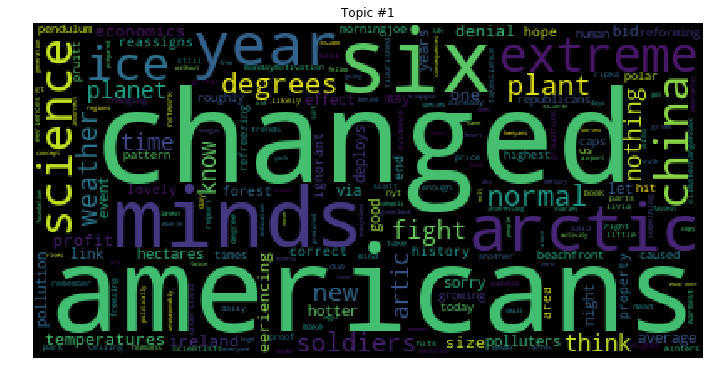

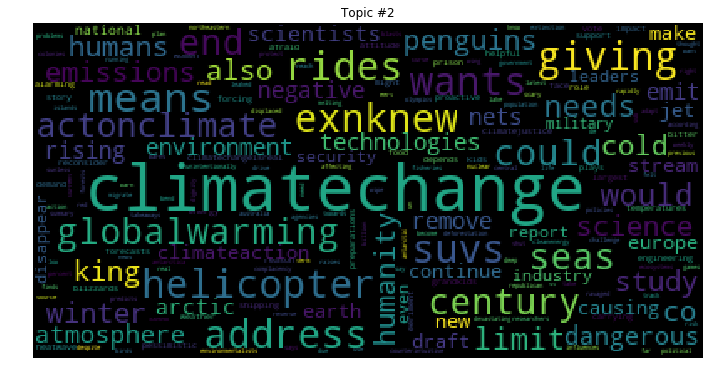

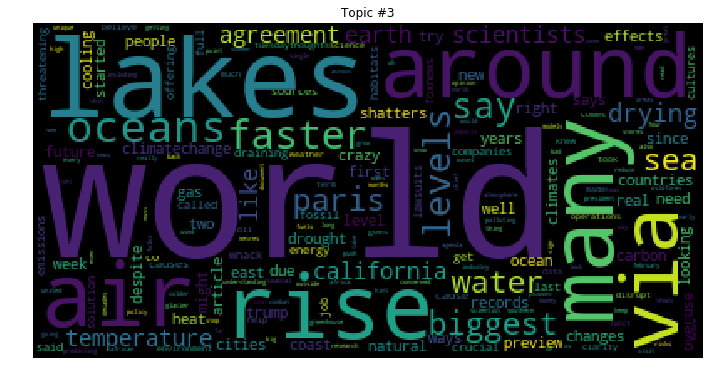

In [143]:
for t in range(4):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud().fit_words(dict(get_word_freq(t, all_lda, 200, vocab))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

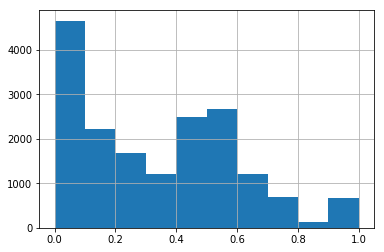

In [101]:
sampleDF.Subjectivity.hist()

In [116]:
sampleDF[sampleDF.Polarity < 0.1].groupby('topic_LDA')['Polarity'].count()

topic_LDA
0    1106
1    3419
2    1627
3    5463
Name: Polarity, dtype: int64

In [113]:
sampleDF[sampleDF.Polarity >= 0.1].groupby('topic_LDA')['Polarity'].count()

topic_LDA
0    244 
1    1945
2    1320
3    2455
Name: Polarity, dtype: int64

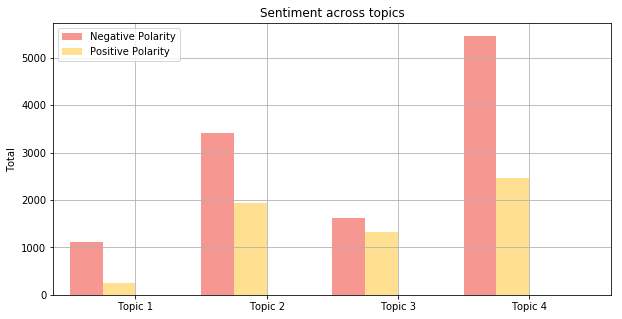

In [123]:
# Setting the positions and width for the bars
pos = list(range(4)) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        sampleDF[sampleDF.Polarity < 0.1].groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label=['Topic 1','Topic 2', 'Topic 3', 'Topic 4'])

plt.bar([p + width for p in pos], 
        #using df['pre_score'] data,
        sampleDF[sampleDF.Polarity >= 0.1].groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the first value in first_name
        label=['Topic 1','Topic 2', 'Topic 3', 'Topic 4'])

# Set the y axis label
ax.set_ylabel('Total')

# Set the chart's title
ax.set_title('Sentiment across topics')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(['Topic 1', 'Topic 2', 'Topic 3','Topic 4'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)


# Adding the legend and showing the plot
plt.legend(['Negative Polarity', 'Positive Polarity'], loc='upper left')
plt.grid()
plt.show()

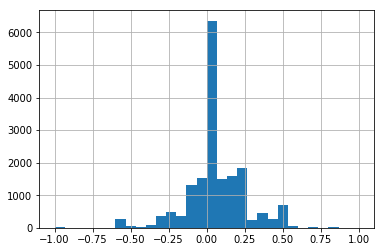

In [108]:
sampleDF.Polarity.hist(bins = 30)

## Full Set

In [176]:
all_lda, all_doc_topics, all_prepared, vocab = get_topics_lda(fullDF['full_text'], 4)


Topic #0:
extreme, ice, science, nothing, degrees, normal, denial, artic, eeriencing, economics, profit, polluters, sea, air, effect, history, weather, highest, earth, struggling

Topic #1:
new, means, people, weather, address, wants, real, giving, exnknew, suvs, helicopter, rides, also, via, changed, one, science, like, know, fight

Topic #2:
arctic, scientists, even, winter, heatwave, forcing, forecasts, reconsider, pessimistic, see, alarming, ever, sunless, wanted, sentence, world, think, around, future, lakes

Topic #3:
trees, million, record, hours, india, part, plants, environmental, campaign, breaking, became, venice, one, snow, ago, pro, attempt, normalize, pedophilia, year


/Users/emilygeller/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [177]:
pyLDAvis.display(all_prepared)

In [178]:
#distribution of topics over the documents
all_doc_topics

array([[0.6263878 , 0.02636405, 0.322248  , 0.02500016],
       [0.65656925, 0.18072672, 0.08079967, 0.08190437],
       [0.6279492 , 0.27204909, 0.05000065, 0.05000106],
       ...,
       [0.0215017 , 0.76952796, 0.1034167 , 0.10555365],
       [0.0965709 , 0.8696112 , 0.01688103, 0.01693687],
       [0.41352152, 0.46114468, 0.02116032, 0.10417349]])

In [185]:
# categorize reviews by most probable topic
fullDF['topic_LDA'] = get_doc_topics(all_doc_topics)

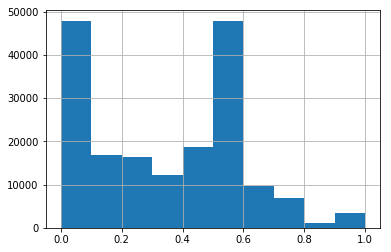

In [186]:
fullDF.Subjectivity.hist()

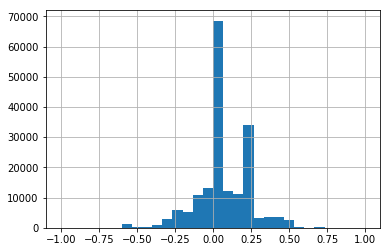

In [187]:
fullDF.Polarity.hist(bins = 30)

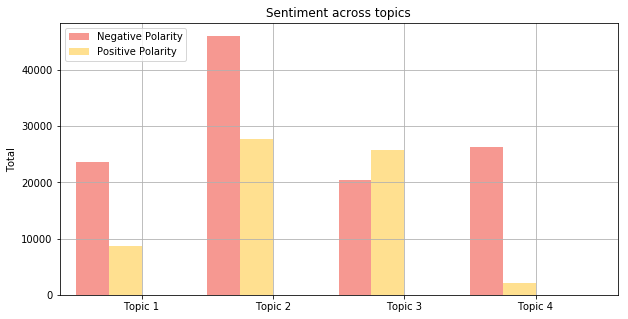

In [188]:
# Setting the positions and width for the bars
pos = list(range(4)) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))
# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        fullDF[fullDF.Polarity < 0.1].groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label=['Topic 1','Topic 2', 'Topic 3', 'Topic 4'])

plt.bar([p + width for p in pos], 
        #using df['pre_score'] data,
        fullDF[fullDF.Polarity >= 0.1].groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the first value in first_name
        label=['Topic 1','Topic 2', 'Topic 3', 'Topic 4'])

# Set the y axis label
ax.set_ylabel('Total')

# Set the chart's title
ax.set_title('Sentiment across topics')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(['Topic 1', 'Topic 2', 'Topic 3','Topic 4'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)


# Adding the legend and showing the plot
plt.legend(['Negative Polarity', 'Positive Polarity'], loc='upper left')
plt.grid()
plt.show()

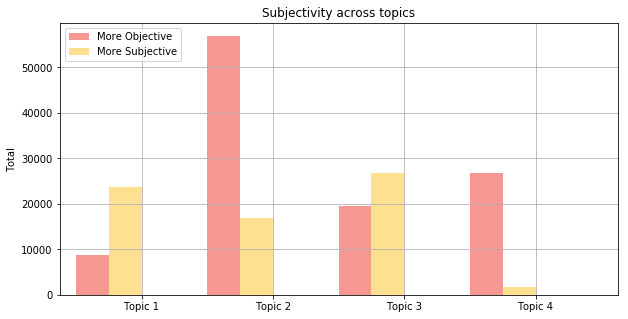

In [189]:
# Setting the positions and width for the bars
pos = list(range(4)) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))
# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        fullDF[fullDF.Subjectivity < 0.5].groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label=['Topic 1','Topic 2', 'Topic 3', 'Topic 4'])

plt.bar([p + width for p in pos], 
        #using df['pre_score'] data,
        fullDF[fullDF.Subjectivity >= 0.5].groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the first value in first_name
        label=['Topic 1','Topic 2', 'Topic 3', 'Topic 4'])

# Set the y axis label
ax.set_ylabel('Total')

# Set the chart's title
ax.set_title('Subjectivity across topics')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(['Topic 1', 'Topic 2', 'Topic 3','Topic 4'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)


# Adding the legend and showing the plot
plt.legend(['More Objective', 'More Subjective'], loc='upper left')
plt.grid()
plt.show()

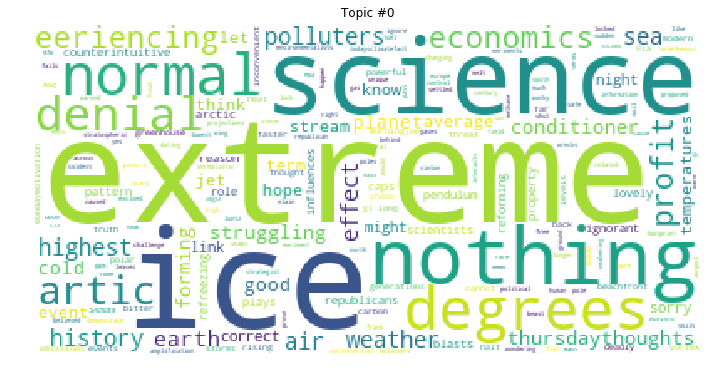

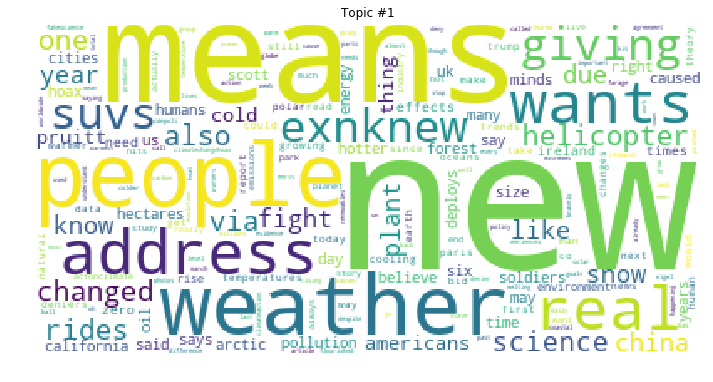

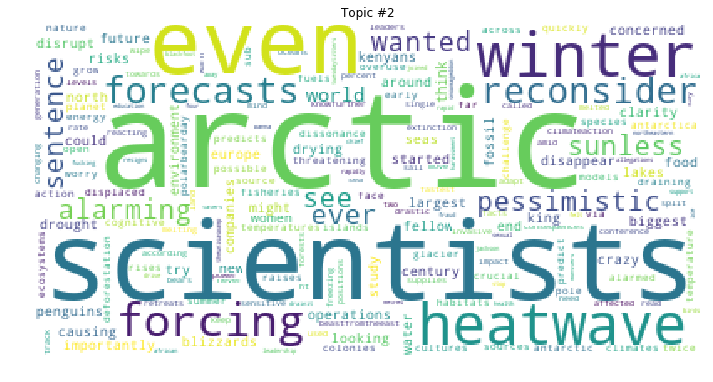

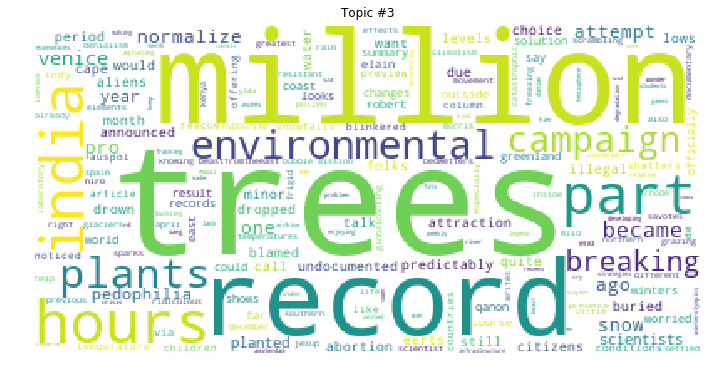

In [193]:
for t in range(4):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud(background_color='white').fit_words(dict(get_word_freq(t, all_lda, 200, vocab))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

In [201]:
fullDF[(fullDF.Polarity < 0.1)&(fullDF.topic_LDA == 0)].full_text

0         memo from activist lawyer to outlines strategy to charge energy companies with causing global warming                                                                                                                                                                              
1         there s a huge difference between climate and weather the arctic is eeriencing unusually high temperatures as a result of global warming which has pushed colder air further south causing snow and very cold temperatures in britain there s reams of science behind it           
2         what are climate change global warming greenhouses gasses difference between weather and climate                                                                                                                                                                                   
3         what are climate change global warming greenhouses gasses difference between weather and climate via visually disasters             

Topic 0


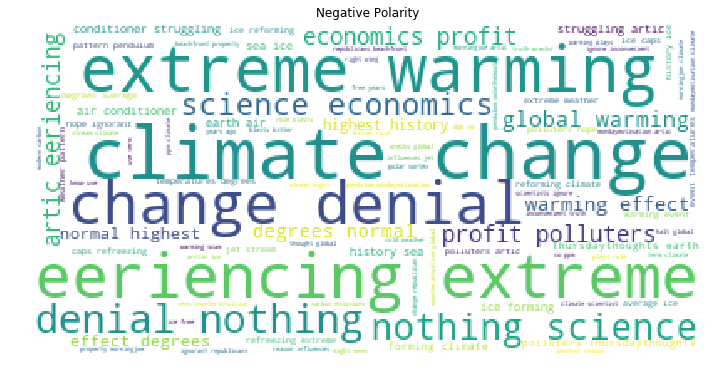

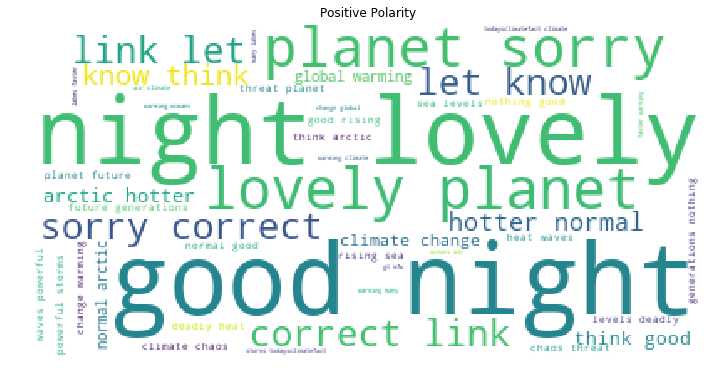

Topic 1


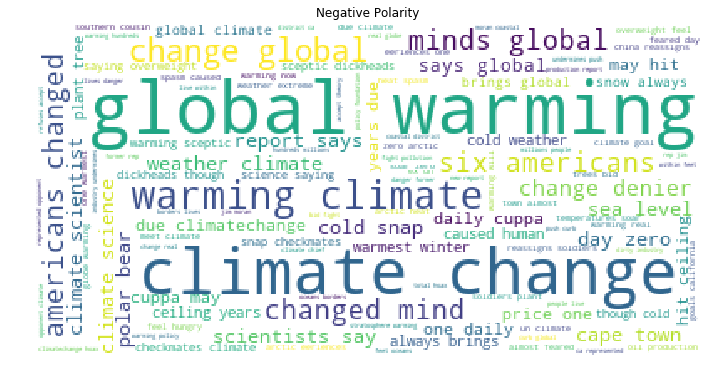

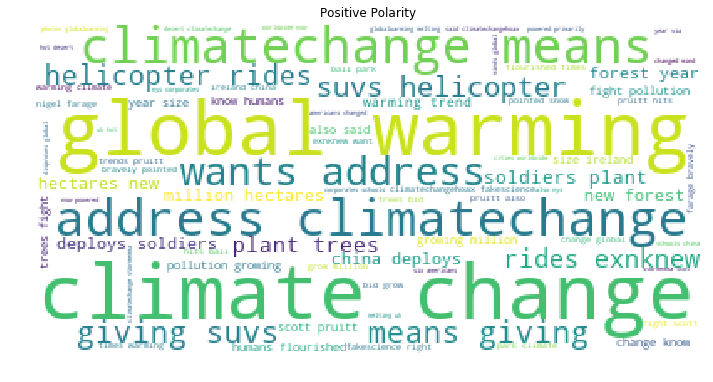

Topic 2


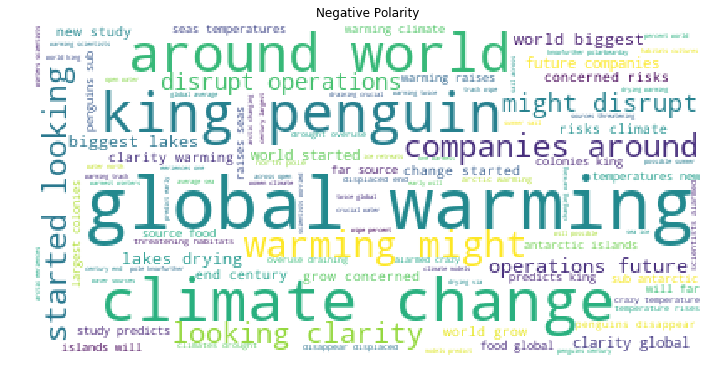

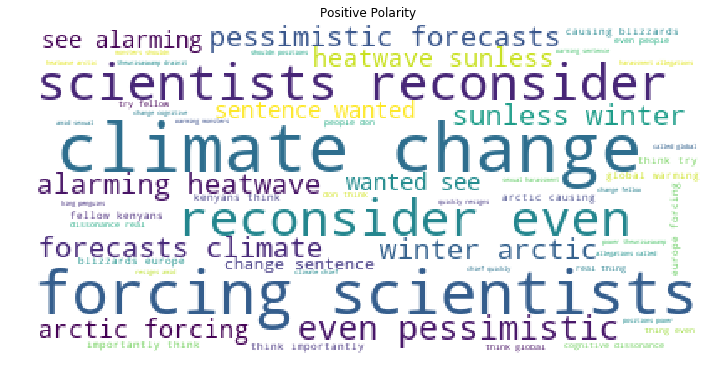

Topic 3


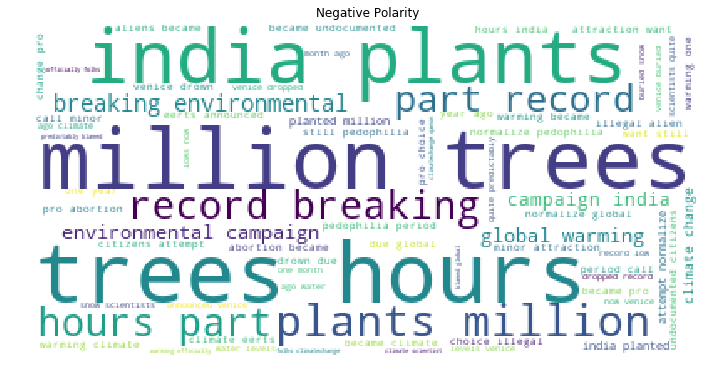

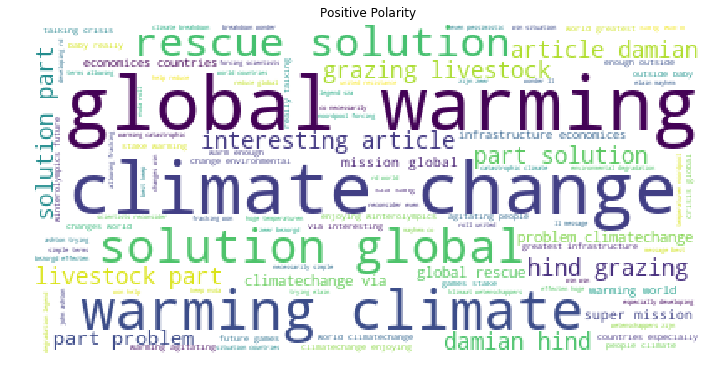

In [208]:


for t in range(4):
    
    print('Topic', t)
    
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud(background_color='white').generate(fullDF[(fullDF.Polarity < 0.1)&(fullDF.topic_LDA == t)].full_text.str.cat(sep=' ')))
    plt.axis('off')
    plt.title('Negative Polarity')
    plt.show()
               
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud(background_color='white').generate(fullDF[(fullDF.Polarity >= 0.1)&(fullDF.topic_LDA == t)].full_text.str.cat(sep=' ')))
    plt.axis('off')
    plt.title('Positive Polarity')
    plt.show()